In [5]:
import pandas as pd
import plotly.express as px

# --------------------------------------------------
# 1) CSV laden (mit ; als Separator)
# --------------------------------------------------
df = pd.read_csv("data/final_bridge_statistic_germany.csv", sep=";")

# Falls "Baujahr Überbau" nicht sauber numerisch ist:
df["Baujahr Überbau"] = pd.to_numeric(df["Baujahr Überbau"], errors="coerce")

# --------------------------------------------------
# 2) Alter berechnen
#    -> hier als Beispiel: Alter = 2025 - Baujahr
#    (Jahr ggf. an dein Inspektionsjahr anpassen)
# --------------------------------------------------
df["Alter"] = 2025 - df["Baujahr Überbau"]



In [6]:
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# ---------------------------------------------------
# Daten laden & vorbereiten
# ---------------------------------------------------
df = pd.read_csv("data/final_bridge_statistic_germany.csv", sep=";")
df["Baujahr Überbau"] = pd.to_numeric(df["Baujahr Überbau"], errors="coerce")
df["Alter"] = 2025 - df["Baujahr Überbau"]

bundeslaender = sorted(df["Bundeslandname"].dropna().unique())

app = dash.Dash(__name__)

# ---------------------------------------------------
# Layout
# ---------------------------------------------------
app.layout = html.Div([
    html.H3("Brücken: Alter vs. Zustandsnote / Traglastindex"),

    html.Div([
        html.P("Bundesländer auswählen:"),
        dcc.Checklist(
            id="bundesland-checklist",
            options=[{"label": b, "value": b} for b in bundeslaender],
            value=bundeslaender,
            inline=False,
        ),
    ], style={"maxHeight": "300px", "overflowY": "auto",
              "border": "1px solid #ccc", "padding": "5px", "marginBottom": "10px"}),

    html.Div([
        html.P("Größe auf der y-Achse:"),
        dcc.RadioItems(
            id="y-metric",
            options=[
                {"label": "Zustandsnote", "value": "Zustandsnote"},
                {"label": "Traglastindex", "value": "Traglastindex"},
            ],
            value="Zustandsnote",   # Start: Zustandsnote
            inline=True,
        ),
    ], style={"marginBottom": "10px"}),

    dcc.Graph(id="scatter_zustand_alter")
])

# ---------------------------------------------------
# Callback: Filter + y-Achsen-Auswahl
# ---------------------------------------------------
@app.callback(
    Output("scatter_zustand_alter", "figure"),
    Input("bundesland-checklist", "value"),
    Input("y-metric", "value")
)
def update_scatter(selected_bundeslaender, selected_metric):
    # Filter nach Bundesland
    if not selected_bundeslaender:
        dff = df.iloc[0:0]
    else:
        dff = df[df["Bundeslandname"].isin(selected_bundeslaender)]

    # y-Achsentitel je nach Auswahl
    if selected_metric == "Zustandsnote":
        y_title = "Zustandsnote"
    else:
        y_title = "Traglastindex"

    fig = px.scatter(
        dff,
        x="Alter",
        y=selected_metric,            # <- hier dynamisch
        hover_data=[
            "Bauwerksname",
            "Baujahr Überbau",
            "Zustandsnote",
            "Traglastindex",
            "Baustoffklasse",
            "Kreis",
            "Bundeslandname",
            "Länge (m)",
            "Breite (m)",
        ],
        color="Bundeslandname",       # jede Farbe = anderes Bundesland
        render_mode="webgl",
    )

    fig.update_traces(
        mode="markers",
        marker=dict(
            size=5,
            opacity=0.7,
        )
    )

    fig.update_layout(
        xaxis_title="Alter der Brücke (Jahre)",
        yaxis_title=y_title,
        template="plotly_white",
        legend_title_text="Bundesland",
    )

    return fig


if __name__ == "__main__":
    app.run(debug=True)


OSError: Address 'http://127.0.0.1:8050' already in use.
    Try passing a different port to run.

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

# ---------------------------------------------------
# Daten laden & vorbereiten
# ---------------------------------------------------
df = pd.read_csv("data/final_bridge_statistic_germany.csv", sep=";")

# Saubere Typen
df["Baujahr Überbau"] = pd.to_numeric(df["Baujahr Überbau"], errors="coerce")
df["Zustandsnote"] = pd.to_numeric(df["Zustandsnote"], errors="coerce")
df["Traglastindex"] = pd.to_numeric(df["Traglastindex"], errors="coerce")
df["Länge (m)"] = pd.to_numeric(df["Länge (m)"], errors="coerce")

# Alter berechnen (Jahr anpassen, falls anderes Referenzjahr sinnvoll ist)
df["Alter"] = 2025 - df["Baujahr Überbau"]

# Nur Thüringen & Sachsen-Anhalt
df_two = df[df["Bundeslandname"].isin(["Thueringen", "Sachsen-Anhalt"])].copy()

# Kleine Kategorie für Straßenart (Autobahn / Bundesstraße / Sonstige)
# ich gehe davon aus, dass "Zugeordneter Sachverhalt vereinfacht"
# z. B. "A", "B" etc. enthält
def map_strassenart(code):
    if pd.isna(code):
        return "Sonstige"
    code = str(code).strip().upper()
    if code.startswith("A"):
        return "Autobahn"
    if code.startswith("B"):
        return "Bundesstraße"
    return "Sonstige"

df_two["Strassenart"] = df_two["Zugeordneter Sachverhalt vereinfacht"].apply(map_strassenart)

# ---------------------------------------------------
# Hilfsfunktion: CI für Mittelwert (approx. 95%-CI)
# ---------------------------------------------------
def ci_for_mean(x, z=1.96):
    x = x.dropna()
    n = len(x)
    if n == 0:
        return np.nan, np.nan
    mean = x.mean()
    se = x.std(ddof=1) / np.sqrt(n)
    ci = z * se
    return mean, ci

# ---------------------------------------------------
# 1) Zustandsnote + Traglastindex mit "Konfidenzintervall"
# ---------------------------------------------------
rows = []
for land in ["Thueringen", "Sachsen-Anhalt"]:
    sub = df_two[df_two["Bundeslandname"] == land]

    for col, label in [
        ("Zustandsnote", "Zustandsnote"),
        ("Traglastindex", "Traglastindex"),
    ]:
        m, ci = ci_for_mean(sub[col])
        rows.append({
            "Bundeslandname": land,
            "Kennzahl": label,
            "Mittelwert": m,
            "CI": ci,
        })

summary_ci = pd.DataFrame(rows)

fig_ci = px.bar(
    summary_ci,
    x="Kennzahl",
    y="Mittelwert",
    color="Bundeslandname",
    barmode="group",
    error_y="CI",
    title="Durchschnittliche Zustandsnote & Traglastindex (mit Fehlerbalken)",
)
fig_ci.update_layout(
    template="plotly_white",
    yaxis_title="Mittelwert (± 95%-CI)",
)
fig_ci.show()

# ---------------------------------------------------
# 2) Verteilung von Alter und Länge der Brücken
#    (Violinplots oder Boxplots)
# ---------------------------------------------------
fig_age = px.violin(
    df_two,
    x="Bundeslandname",
    y="Alter",
    box=True,
    points="all",
    hover_data=["Bauwerksname", "Baujahr Überbau", "Zustandsnote"],
    title="Verteilung des Brückenalters: Thüringen vs. Sachsen-Anhalt",
)
fig_age.update_layout(template="plotly_white", yaxis_title="Alter (Jahre)")
fig_age.show()

fig_len = px.violin(
    df_two,
    x="Bundeslandname",
    y="Länge (m)",
    box=True,
    points="all",
    hover_data=["Bauwerksname", "Zustandsnote", "Traglastindex"],
    title="Verteilung der Brückenlängen: Thüringen vs. Sachsen-Anhalt",
)
fig_len.update_layout(template="plotly_white", yaxis_title="Länge (m)")
fig_len.show()

# ---------------------------------------------------
# 3) Verteilung der Baustoffklassen
# ---------------------------------------------------
fig_baustoff = px.histogram(
    df_two,
    x="Baustoffklasse",
    color="Bundeslandname",
    barmode="group",
    histnorm="percent",   # Prozent-Anteile statt absolute Zahlen
    title="Baustoffklassen-Verteilung in Thüringen vs. Sachsen-Anhalt",
)
fig_baustoff.update_layout(
    template="plotly_white",
    yaxis_title="Anteil (%)",
    xaxis_title="Baustoffklasse",
)
fig_baustoff.show()

# Optional: Gestapelt relativ (zeigt Struktur / Mischung pro Bundesland)
fig_baustoff_rel = px.histogram(
    df_two,
    x="Bundeslandname",
    color="Baustoffklasse",
    barmode="relative",
    histnorm="percent",
    title="Mischung der Baustoffklassen je Bundesland (relative Anteile)",
)
fig_baustoff_rel.update_layout(
    template="plotly_white",
    yaxis_title="Anteil (%)",
    xaxis_title="Bundesland",
)
fig_baustoff_rel.show()

# ---------------------------------------------------
# 4) Bundesstraße vs. Autobahn vs. Sonstige je Bundesland
# ---------------------------------------------------
fig_strasse = px.histogram(
    df_two,
    x="Bundeslandname",
    color="Strassenart",
    barmode="relative",
    histnorm="percent",
    title="Straßenart (Autobahn/Bundesstraße/Sonstige) je Bundesland",
)
fig_strasse.update_layout(
    template="plotly_white",
    yaxis_title="Anteil (%)",
    xaxis_title="Bundesland",
    legend_title_text="Straßenart",
)
fig_strasse.show()

# ---------------------------------------------------
# 5) Scatter: Alter vs. Zustandsnote nach Bundesland
# ---------------------------------------------------
fig_scatter_zustand = px.scatter(
    df_two,
    x="Alter",
    y="Zustandsnote",
    color="Bundeslandname",
    hover_data=[
        "Bauwerksname",
        "Baujahr Überbau",
        "Länge (m)",
        "Baustoffklasse",
        "Strassenart",
    ],
    trendline="ols",  # einfache Regressionslinie je Bundesland
    title="Zustandsnote in Abhängigkeit vom Alter (Thüringen vs. Sachsen-Anhalt)",
)
fig_scatter_zustand.update_layout(
    template="plotly_white",
    xaxis_title="Alter (Jahre)",
    yaxis_title="Zustandsnote",
)
fig_scatter_zustand.show()

# ---------------------------------------------------
# 6) Optional: Scatter Länge vs. Traglastindex
# ---------------------------------------------------
fig_scatter_len_trag = px.scatter(
    df_two,
    x="Länge (m)",
    y="Traglastindex",
    color="Bundeslandname",
    hover_data=[
        "Bauwerksname",
        "Alter",
        "Baustoffklasse",
        "Strassenart",
    ],
    title="Traglastindex in Abhängigkeit von der Brückenlänge",
)
fig_scatter_len_trag.update_layout(
    template="plotly_white",
    xaxis_title="Länge (m)",
    yaxis_title="Traglastindex",
    
)
fig_scatter_len_trag.show()

# # ---------------------------------------------------
# # 6b) Scatter: Alter vs. Traglastindex (mit Offset, damit Punkte nicht überlappen)
# # ---------------------------------------------------
# df_plot = df_two.copy()

# # fester Offset pro Bundesland (in Jahren) – ggf. anpassen (z.B. 0.15 bis 0.4)
# offset_map = {"Thueringen": -0.25, "Sachsen-Anhalt": 0.25}
# df_plot["Alter_plot"] = df_plot["Alter"] + df_plot["Bundeslandname"].map(offset_map)

# fig_scatter_age_trag = px.scatter(
#     df_plot,
#     x="Alter_plot",
#     y="Traglastindex",
#     color="Bundeslandname",
#     hover_data=[
#         "Bauwerksname",
#         "Alter",              # Originalwert im Hover behalten
#         "Baujahr Überbau",
#         "Länge (m)",
#         "Baustoffklasse",
#         "Strassenart",
#     ],
#     title="Traglastindex in Abhängigkeit vom Alter (versetzt: Thüringen vs. Sachsen-Anhalt)",
# )

# fig_scatter_age_trag.update_layout(
#     template="plotly_white",
#     xaxis_title="Alter (Jahre) – leicht versetzt nach Bundesland",
#     yaxis_title="Traglastindex",
# )
# fig_scatter_age_trag.show()



In [ ]:
fig_box = px.box(
    df,
    x="Baustoffklasse",
    y="Zustandsnote",
    points="all",  # zeigt alle Punkte, kannst du auf "outliers" ändern
    title="Verteilung der Zustandsnoten nach Baustoffklasse",
)

fig_box.update_layout(
    template="plotly_white",
    xaxis_title="Baustoffklasse",
    yaxis_title="Zustandsnote",
)

fig_box.show()


In [ ]:
df_two = df[df["Bundeslandname"].isin(["Thueringen", "Sachsen-Anhalt"])].copy()

fig_bundesland_baustoff = px.box(
    df_two,
    x="Baustoffklasse",
    y="Zustandsnote",
    color="Bundeslandname",
    points="all",
    title="Zustandsnoten nach Baustoffklasse und Bundesland",
)

fig_bundesland_baustoff.update_layout(
    template="plotly_white",
    xaxis_title="Baustoffklasse",
    yaxis_title="Zustandsnote",
    legend_title_text="Bundesland",
)

fig_bundesland_baustoff.show()
fig_baustoff = px.histogram(
    df_two,
    x="Baustoffklasse",
    color="Bundeslandname",
    barmode="group",
    histnorm="percent",   # Prozent-Anteile statt absolute Zahlen
    title="Baustoffklassen-Verteilung in Thüringen vs. Sachsen-Anhalt",
)
fig_baustoff.update_layout(
    template="plotly_white",
    yaxis_title="Anteil (%)",
    xaxis_title="Baustoffklasse",
)
fig_baustoff.show()


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

# ---------------------------------------------------
# Daten laden & vorbereiten
# ---------------------------------------------------

# Relevante Spalten in numerisch bringen
df["Baujahr Überbau"] = pd.to_numeric(df["Baujahr Überbau"], errors="coerce")
df["Zustandsnote"] = pd.to_numeric(df["Zustandsnote"], errors="coerce")

# Alter der Brücke (Jahr ggf. anpassen)
df["Alter"] = 2025 - df["Baujahr Überbau"]

# Nur Thüringen & Sachsen-Anhalt
df_two = df[df["Bundeslandname"].isin(["Thueringen", "Sachsen-Anhalt"])].copy()

# Altersklassen definieren
bins = [0, 10, 20,30, 40, 50, 60, 70, 80, 90, 100, 200]
labels = ["<10","10-19","20–29","30–39","40–49","50–59","60–69" ,"70–79", "80–89", "90–99", "100+"]
df_two["Alterklasse"] = pd.cut(df_two["Alter"], bins=bins, labels=labels, right=False)

# ---------------------------------------------------
# 1) Scatter: Alter vs. Zustandsnote mit Trendlinie je Bundesland
# ---------------------------------------------------
fig_scatter = px.scatter(
    df_two,
    x="Alter",
    y="Zustandsnote",
    color="Bundeslandname",
    hover_data=[
        "Bauwerksname",
        "Baujahr Überbau",
        "Baustoffklasse",
        "Kreis",
    ],
    trendline="ols",          # einfache Regression je Bundesland
    trendline_scope="trace",  # je Trace (also je Bundesland)
    title="Zustandsnote in Abhängigkeit vom Alter – Thüringen vs. Sachsen-Anhalt",
)

fig_scatter.update_layout(
    template="plotly_white",
    xaxis_title="Alter der Brücke (Jahre)",
    yaxis_title="Zustandsnote",
    legend_title_text="Bundesland",
)
fig_scatter.show()

# ---------------------------------------------------
# 2) Verteilung der Zustandsnoten nach Altersklasse & Bundesland (Box/Violin)
# ---------------------------------------------------
# Boxplot
fig_box = px.box(
    df_two,
    x="Alterklasse",
    y="Zustandsnote",
    color="Bundeslandname",
    category_orders={"Alterklasse": labels},
    points="all",  # alle Punkte sichtbar; alternativ "outliers"
    title="Zustandsnoten nach Altersklassen – Thüringen vs. Sachsen-Anhalt",
)
fig_box.update_layout(
    template="plotly_white",
    xaxis_title="Altersklasse (Jahre)",
    yaxis_title="Zustandsnote",
    legend_title_text="Bundesland",
)
fig_box.show()


# '# ---------------------------------------------------
# # 3) Mittelwert + (ungefähres) 95%-Konfidenzintervall je Altersklasse & Bundesland
# # ---------------------------------------------------
# def ci_for_mean(x, z=1.96):
#     x = x.dropna()
#     n = len(x)
#     if n == 0:
#         return np.nan, np.nan
#     mean = x.mean()
#     se = x.std(ddof=1) / np.sqrt(n)
#     ci = z * se
#     return mean, ci

# rows = []
# for (land, ak), grp in df_two.groupby(["Bundeslandname", "Alterklasse"]):
#     if pd.isna(ak):
#         continue
#     mean, ci = ci_for_mean(grp["Zustandsnote"])
#     rows.append({
#         "Bundeslandname": land,
#         "Alterklasse": ak,
#         "mean_zustand": mean,
#         "ci": ci,
#         "n": len(grp),
#     })

# agg = pd.DataFrame(rows)
# agg["Alterklasse"] = agg["Alterklasse"].astype(str)
# agg = agg.sort_values(["Alterklasse", "Bundeslandname"])

# fig_ci.update_traces(textposition="outside")



In [ ]:
import re
import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 1) Einlesen (CSV mit Semikolon)
# ------------------------------------------------------------
df = pd.read_csv("data/final_bridge_statistic_germany.csv", sep=";", encoding="utf-8")  # Pfad anpassen

# ------------------------------------------------------------
# 2) Bundeslandnamen robust normalisieren (für Schreibvarianten)
# ------------------------------------------------------------
def norm_state(x: object) -> str:
    s = str(x).strip().lower()
    s = (s.replace("ü", "ue")
           .replace("ö", "oe")
           .replace("ä", "ae")
           .replace("ß", "ss"))
    s = re.sub(r"\s+", " ", s)
    s = s.replace("-", " ")  # "Sachsen-Anhalt" == "Sachsen Anhalt"
    return s

df["state_norm"] = df["Bundeslandname"].map(norm_state)

targets = {
    "thueringen": "Thüringen",
    "sachsen anhalt": "Sachsen-Anhalt",
}

df = df[df["state_norm"].isin(targets)].copy()
df["Bundesland"] = df["state_norm"].map(targets)

# ------------------------------------------------------------
# 3) Zahlen sauber casten
# ------------------------------------------------------------
num_cols = ["GDP 2022", "Bevölkerung (insgesamt)", "Fläche (qkm)"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ------------------------------------------------------------
# 4) Wichtig: GDP/Population sind Kreis-Level und in deinen Daten pro Brücke wiederholt.
#    Deshalb erst pro (Bundesland, Kreis) deduplizieren, sonst würdest du vielfach zählen.
# ------------------------------------------------------------
kreise = (
    df[["Bundesland", "Kreis", "GDP 2022", "Bevölkerung (insgesamt)", "Fläche (qkm)"]]
    .drop_duplicates(subset=["Bundesland", "Kreis"])
)

# Brückenanzahl je Bundesland (Zeilen = Brücken)
bridge_counts = df.groupby("Bundesland").size().rename("Anzahl_Bruecken")

# Aggregation je Bundesland
agg = (
    kreise.groupby("Bundesland")
    .agg(
        Anzahl_Kreise=("Kreis", "nunique"),
        GDP_sum=("GDP 2022", "sum"),
        GDP_mean_pro_Kreis=("GDP 2022", "mean"),
        Pop_sum=("Bevölkerung (insgesamt)", "sum"),
        Pop_mean_pro_Kreis=("Bevölkerung (insgesamt)", "mean"),
        Flaeche_sum=("Fläche (qkm)", "sum"),
    )
    .join(bridge_counts, how="left")
)

# GDP pro Kopf (Annahme: GDP 2022 ist in Mio. €, dann *1e6 => €)
agg["GDP_pro_Kopf_EUR"] = (agg["GDP_sum"] * 1e6) / agg["Pop_sum"]

print("\n=== Aggregation Thüringen vs Sachsen-Anhalt ===")
print(agg)

# ------------------------------------------------------------
# 5) Unterschiede (Thüringen - Sachsen-Anhalt): absolut + relativ
# ------------------------------------------------------------
th = agg.loc["Thüringen"]
sa = agg.loc["Sachsen-Anhalt"]

diff_abs = th - sa
diff_pct = (diff_abs / sa.replace(0, np.nan)) * 100

out = pd.DataFrame({
    "Sachsen-Anhalt": sa,
    "Thüringen": th,
    "Differenz_abs (TH - SA)": diff_abs,
    "Differenz_% (vs SA)": diff_pct,
})

print("\n=== Unterschiede (TH - SA) ===")
print(out.loc[[
    "Anzahl_Bruecken",
    "Anzahl_Kreise",
    "GDP_sum",
    "Pop_sum",
    "GDP_pro_Kopf_EUR",
    "GDP_mean_pro_Kreis",
    "Pop_mean_pro_Kreis",
]])

# ------------------------------------------------------------
# 6) Optional: Verteilungen auf Kreis-Ebene vergleichen (Mittelwert/Median + Tests)
# ------------------------------------------------------------
desc = kreise.groupby("Bundesland")[["GDP 2022", "Bevölkerung (insgesamt)"]].describe()
print("\n=== Kreis-Ebene: Deskriptive Statistik ===")
print(desc)

try:
    from scipy import stats

    gdp_th = kreise.loc[kreise["Bundesland"] == "Thüringen", "GDP 2022"].dropna()
    gdp_sa = kreise.loc[kreise["Bundesland"] == "Sachsen-Anhalt", "GDP 2022"].dropna()

    pop_th = kreise.loc[kreise["Bundesland"] == "Thüringen", "Bevölkerung (insgesamt)"].dropna()
    pop_sa = kreise.loc[kreise["Bundesland"] == "Sachsen-Anhalt", "Bevölkerung (insgesamt)"].dropna()

    # Welch t-test (ungleiche Varianzen)
    print("\n=== Welch t-test (Kreis-Ebene) ===")
    print("GDP 2022:", stats.ttest_ind(gdp_th, gdp_sa, equal_var=False))
    print("Population:", stats.ttest_ind(pop_th, pop_sa, equal_var=False))

    # Mann-Whitney U (robust gegen Ausreißer/nicht-normal)
    print("\n=== Mann-Whitney U (Kreis-Ebene) ===")
    print("GDP 2022:", stats.mannwhitneyu(gdp_th, gdp_sa, alternative="two-sided"))
    print("Population:", stats.mannwhitneyu(pop_th, pop_sa, alternative="two-sided"))

except ImportError:
    print("\n(scikit/scipy nicht installiert – Tests übersprungen. Deskriptive Statistik oben funktioniert trotzdem.)")



=== Aggregation Thüringen vs Sachsen-Anhalt ===
                Anzahl_Kreise    GDP_sum  GDP_mean_pro_Kreis  Pop_sum  \
Bundesland                                                              
Sachsen-Anhalt             12  63179.211         5264.934250  1833428   
Thüringen                  24  84501.639         3520.901625  2478312   

                Pop_mean_pro_Kreis  Flaeche_sum  Anzahl_Bruecken  \
Bundesland                                                         
Sachsen-Anhalt       152785.666667     20173.48             1367   
Thüringen            103263.000000     19599.46             1645   

                GDP_pro_Kopf_EUR  
Bundesland                        
Sachsen-Anhalt      34459.608449  
Thüringen           34096.449115  

=== Unterschiede (TH - SA) ===
                    Sachsen-Anhalt     Thüringen  Differenz_abs (TH - SA)  \
Anzahl_Bruecken       1.367000e+03  1.645000e+03               278.000000   
Anzahl_Kreise         1.200000e+01  2.400000e+01           

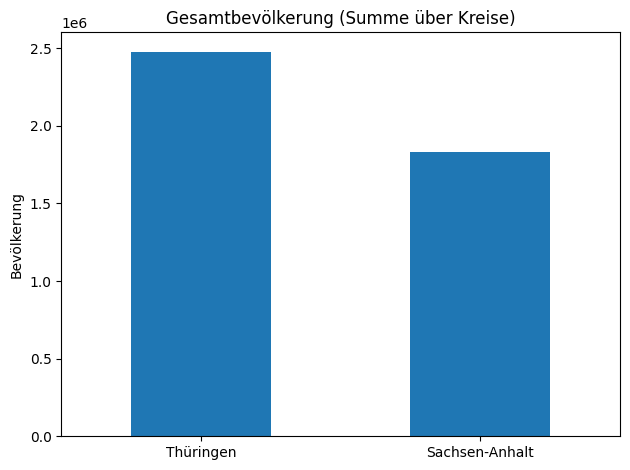

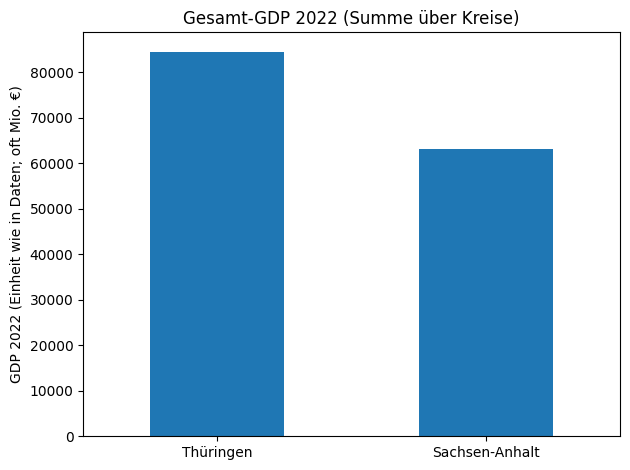

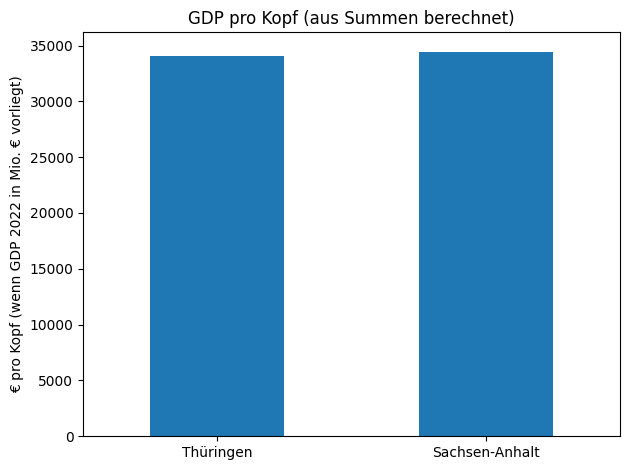

<Figure size 640x480 with 0 Axes>

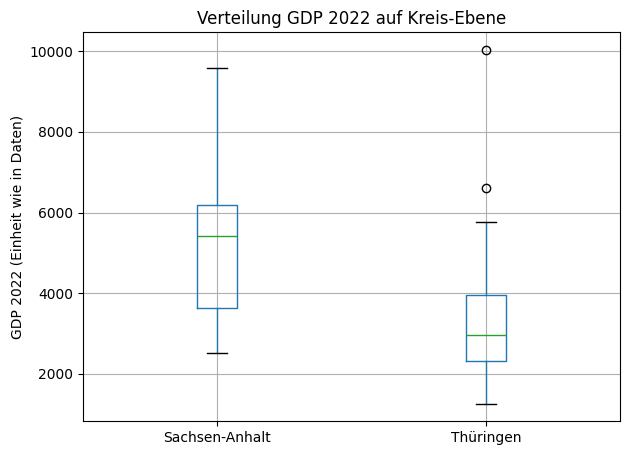

<Figure size 640x480 with 0 Axes>

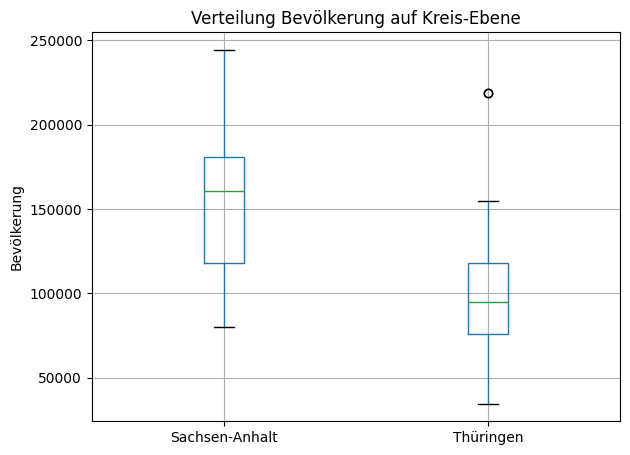

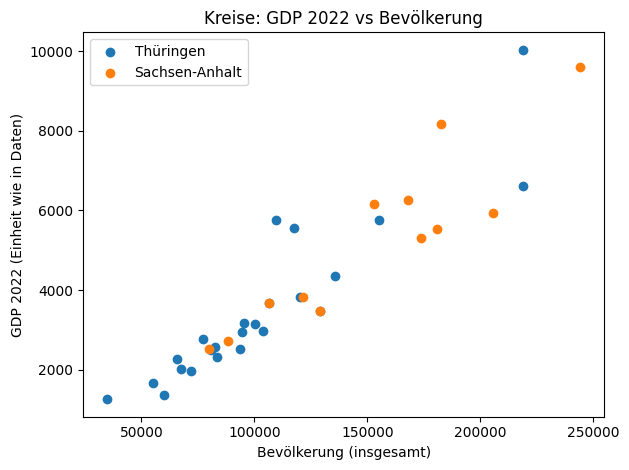

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Einlesen
# -----------------------------

# -----------------------------
# 2) Bundeslandnamen normalisieren
# -----------------------------
def norm_state(x: object) -> str:
    s = str(x).strip().lower()
    s = (s.replace("ü", "ue")
           .replace("ö", "oe")
           .replace("ä", "ae")
           .replace("ß", "ss"))
    s = re.sub(r"\s+", " ", s)
    s = s.replace("-", " ")  # "Sachsen-Anhalt" == "Sachsen Anhalt"
    return s

df["state_norm"] = df["Bundeslandname"].map(norm_state)

targets = {
    "thueringen": "Thüringen",
    "sachsen anhalt": "Sachsen-Anhalt",
}

df = df[df["state_norm"].isin(targets)].copy()
df["Bundesland"] = df["state_norm"].map(targets)

if df.empty:
    raise ValueError("Keine Zeilen für Thüringen/Sachsen-Anhalt gefunden. Prüfe Schreibweise in 'Bundeslandname'.")

# -----------------------------
# 3) Zahlen casten
# -----------------------------
for c in ["GDP 2022", "Bevölkerung (insgesamt)", "Fläche (qkm)"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# -----------------------------
# 4) Dedup auf Kreis-Ebene (sonst würdest du GDP/Population pro Brücke mehrfach zählen)
# -----------------------------
kreise = (
    df[["Bundesland", "Kreis", "GDP 2022", "Bevölkerung (insgesamt)", "Fläche (qkm)"]]
    .drop_duplicates(subset=["Bundesland", "Kreis"])
)

# Aggregation je Bundesland
agg = kreise.groupby("Bundesland").agg(
    GDP_sum=("GDP 2022", "sum"),
    Pop_sum=("Bevölkerung (insgesamt)", "sum"),
    GDP_mean_pro_Kreis=("GDP 2022", "mean"),
    Pop_mean_pro_Kreis=("Bevölkerung (insgesamt)", "mean"),
)

# GDP pro Kopf (ANNAHME: "GDP 2022" ist in Mio. € -> *1e6 => €)
agg["GDP_pro_Kopf_EUR"] = (agg["GDP_sum"] * 1e6) / agg["Pop_sum"]

# Reihenfolge fix
agg = agg.reindex(["Thüringen", "Sachsen-Anhalt"])

# -----------------------------
# 5) Diagramme
# -----------------------------

# (A) Balkendiagramm: Gesamtbevölkerung
plt.figure()
agg["Pop_sum"].plot(kind="bar")
plt.title("Gesamtbevölkerung (Summe über Kreise)")
plt.ylabel("Bevölkerung")
plt.xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# (B) Balkendiagramm: Gesamt-GDP
plt.figure()
agg["GDP_sum"].plot(kind="bar")
plt.title("Gesamt-GDP 2022 (Summe über Kreise)")
plt.ylabel("GDP 2022 (Einheit wie in Daten; oft Mio. €)")
plt.xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# (C) Balkendiagramm: GDP pro Kopf
plt.figure()
agg["GDP_pro_Kopf_EUR"].plot(kind="bar")
plt.title("GDP pro Kopf (aus Summen berechnet)")
plt.ylabel("€ pro Kopf (wenn GDP 2022 in Mio. € vorliegt)")
plt.xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# (D) Optional: Boxplots auf Kreis-Ebene (zeigt Verteilung/Unterschiede zwischen Kreisen)
# GDP
plt.figure()
kreise.boxplot(column="GDP 2022", by="Bundesland")
plt.title("Verteilung GDP 2022 auf Kreis-Ebene")
plt.suptitle("")  # entfernt Standard-Überschrift
plt.ylabel("GDP 2022 (Einheit wie in Daten)")
plt.xlabel("")
plt.tight_layout()
plt.show()

# Bevölkerung
plt.figure()
kreise.boxplot(column="Bevölkerung (insgesamt)", by="Bundesland")
plt.title("Verteilung Bevölkerung auf Kreis-Ebene")
plt.suptitle("")
plt.ylabel("Bevölkerung")
plt.xlabel("")
plt.tight_layout()
plt.show()

# -----------------------------
# 6) Optional: Kreis-Scatter (GDP vs Bevölkerung) je Bundesland
# -----------------------------
plt.figure()
for state in ["Thüringen", "Sachsen-Anhalt"]:
    sub = kreise[kreise["Bundesland"] == state]
    plt.scatter(sub["Bevölkerung (insgesamt)"], sub["GDP 2022"], label=state)

plt.title("Kreise: GDP 2022 vs Bevölkerung")
plt.xlabel("Bevölkerung (insgesamt)")
plt.ylabel("GDP 2022 (Einheit wie in Daten)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

# -------------------------
# Pfade
# -------------------------
csv_path = Path("data/final_bridge_statistic_germany.csv")

# -------------------------
# Helpers
# -------------------------
def norm_state(x: object) -> str:
    s = str(x).strip().lower()
    s = s.replace("ü","ue").replace("ö","oe").replace("ä","ae").replace("ß","ss")
    s = re.sub(r"\s+", " ", s)
    s = s.replace("-", " ")  # Sachsen-Anhalt == Sachsen Anhalt
    return s

TARGET = {"thueringen", "sachsen anhalt"}

def to_num(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series.astype(str).str.replace(",", ".", regex=False), errors="coerce")

# -------------------------
# 1) Daten laden + Spaltennamen bereinigen
# -------------------------
df = pd.read_csv(csv_path, sep=";", decimal=",", dtype=str, keep_default_na=False)

df.columns = (
    df.columns.astype(str)
      .str.replace("\u00A0", " ", regex=False)   # NBSP -> Space
      .str.strip()
      .str.replace(r"\s+", " ", regex=True)
)

# Benötigte Spalten
required = ["Bundeslandname", "Kreis", "GDP 2022", "Fläche (qkm)", "Bevölkerung (insgesamt)", "Zustandsnote"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Fehlende Spalten: {missing}\nVorhandene Spalten:\n{list(df.columns)}")

# -------------------------
# 2) Filtern auf Thüringen + Sachsen-Anhalt
# -------------------------
df["__state_norm__"] = df["Bundeslandname"].map(norm_state)
df_thst = df[df["__state_norm__"].isin(TARGET)].copy()

# Numerik
df_thst["GDP 2022"] = to_num(df_thst["GDP 2022"])
df_thst["Fläche (qkm)"] = to_num(df_thst["Fläche (qkm)"])
df_thst["Bevölkerung (insgesamt)"] = to_num(df_thst["Bevölkerung (insgesamt)"])
df_thst["Zustandsnote"] = to_num(df_thst["Zustandsnote"])

# -------------------------
# 3) Kreis-Liste (GDP/Fläche/Bevölkerung dedupliziert)
# -------------------------
kreise = (
    df_thst[["Bundeslandname", "__state_norm__", "Kreis", "GDP 2022", "Fläche (qkm)", "Bevölkerung (insgesamt)"]]
    .dropna(subset=["Kreis"])
    .drop_duplicates(subset=["__state_norm__", "Kreis"])   # pro Bundesland+Kreis genau eine Zeile
    .copy()
)
kreise["Bevölkerungsdichte"] = kreise["Bevölkerung (insgesamt)"] / kreise["Fläche (qkm)"]

# -------------------------
# 4) Mean Zustandsnote pro Kreis (über alle Brücken im Kreis)
# -------------------------
zust_kreis = (
    df_thst.dropna(subset=["Kreis", "Zustandsnote"])
    .groupby(["__state_norm__", "Kreis"], as_index=False)
    .agg(
        Mean_Zustandsnote=("Zustandsnote", "mean"),
        Anzahl_Bruecken_mit_Note=("Zustandsnote", "size"),
    )
)

# Merge in kreise
kreise = kreise.merge(zust_kreis, on=["__state_norm__", "Kreis"], how="left")

# -------------------------
# 5) Bundesland-Übersicht (Summe über Kreise) + optional Ø Zustandsnote (ungewichtet & gewichtet)
# -------------------------
state_summary = (
    kreise
    .groupby(["__state_norm__", "Bundeslandname"], as_index=False)
    .agg(
        Kreise=("Kreis", "nunique"),
        GDP_2022_total=("GDP 2022", "sum"),
        Fläche_total_qkm=("Fläche (qkm)", "sum"),
        Bevölkerung_total=("Bevölkerung (insgesamt)", "sum"),
        Mean_Zustandsnote_ungewichtet=("Mean_Zustandsnote", "mean"),
    )
)
state_summary["Bevölkerungsdichte_total"] = state_summary["Bevölkerung_total"] / state_summary["Fläche_total_qkm"]
state_summary["GDP_pro_Kopf"] = state_summary["GDP_2022_total"] / state_summary["Bevölkerung_total"]

# gewichtete Ø Zustandsnote nach Anzahl Brücken (nur wenn Werte vorhanden)
tmp = kreise.dropna(subset=["Mean_Zustandsnote", "Anzahl_Bruecken_mit_Note"]).copy()
if len(tmp) > 0:
    weighted = (
        tmp.groupby(["__state_norm__", "Bundeslandname"], as_index=False)
           .apply(lambda g: np.average(g["Mean_Zustandsnote"], weights=g["Anzahl_Bruecken_mit_Note"]))
           .rename(columns={None: "Mean_Zustandsnote_gewichtet"})
    )
    state_summary = state_summary.merge(weighted, on=["__state_norm__", "Bundeslandname"], how="left")
else:
    state_summary["Mean_Zustandsnote_gewichtet"] = np.nan

# runden für Ausgabe
state_summary["GDP_2022_total"] = state_summary["GDP_2022_total"].round(2)
state_summary["Bevölkerungsdichte_total"] = state_summary["Bevölkerungsdichte_total"].round(2)
state_summary["GDP_pro_Kopf"] = state_summary["GDP_pro_Kopf"].round(4)
state_summary["Mean_Zustandsnote_ungewichtet"] = state_summary["Mean_Zustandsnote_ungewichtet"].round(2)
state_summary["Mean_Zustandsnote_gewichtet"] = state_summary["Mean_Zustandsnote_gewichtet"].round(2)

# -------------------------
# 6) Kreistabellen je Bundesland + Sortierung nach Mean Zustandsnote (schlechteste zuerst)
# -------------------------
kreise_out = kreise.rename(columns={
    "GDP 2022": "GDP_2022",
    "Fläche (qkm)": "Fläche_qkm",
    "Bevölkerung (insgesamt)": "Bevölkerung"
}).copy()

kreise_out["GDP_2022"] = kreise_out["GDP_2022"].round(2)
kreise_out["Bevölkerungsdichte"] = kreise_out["Bevölkerungsdichte"].round(2)
kreise_out["Mean_Zustandsnote"] = kreise_out["Mean_Zustandsnote"].round(2)

# Sortierung: höchste (schlechteste) Zustandsnote zuerst; NaN ans Ende
sort_cols = ["Mean_Zustandsnote", "Kreis"]
kreise_th = (
    kreise_out[kreise_out["__state_norm__"] == "thueringen"]
    .sort_values(sort_cols, ascending=[False, True], na_position="last")
)
kreise_sa = (
    kreise_out[kreise_out["__state_norm__"] == "sachsen anhalt"]
    .sort_values(sort_cols, ascending=[False, True], na_position="last")
)

# -------------------------
# 7) Ausgabe + Export
# -------------------------
print("\n=== Bundesland-Übersicht (TH vs ST) ===")
print(state_summary.sort_values("__state_norm__"))

print("\n=== Kreise Thüringen (nach Mean Zustandsnote, schlecht -> gut) ===")
print(kreise_th[["Kreis","Mean_Zustandsnote","Anzahl_Bruecken_mit_Note","GDP_2022","Fläche_qkm","Bevölkerung","Bevölkerungsdichte"]].head(30))

print("\n=== Kreise Sachsen-Anhalt (nach Mean Zustandsnote, schlecht -> gut) ===")
print(kreise_sa[["Kreis","Mean_Zustandsnote","Anzahl_Bruecken_mit_Note","GDP_2022","Fläche_qkm","Bevölkerung","Bevölkerungsdichte"]].head(30))

# CSV speichern
state_summary.to_csv("summary_thueringen_vs_sachsenanhalt.csv", sep=";", index=False, encoding="utf-8")

kreise_th[["Kreis","Mean_Zustandsnote","Anzahl_Bruecken_mit_Note","GDP_2022","Fläche_qkm","Bevölkerung","Bevölkerungsdichte"]].to_csv(
    "kreise_thueringen_sorted_by_zustand.csv", sep=";", index=False, encoding="utf-8"
)
kreise_sa[["Kreis","Mean_Zustandsnote","Anzahl_Bruecken_mit_Note","GDP_2022","Fläche_qkm","Bevölkerung","Bevölkerungsdichte"]].to_csv(
    "kreise_sachsenanhalt_sorted_by_zustand.csv", sep=";", index=False, encoding="utf-8"
)

print("\nSaved:")
print("- summary_thueringen_vs_sachsenanhalt.csv")
print("- kreise_thueringen_sorted_by_zustand.csv")
print("- kreise_sachsenanhalt_sorted_by_zustand.csv")



=== Bundesland-Übersicht (TH vs ST) ===
   __state_norm__  Bundeslandname  Kreise  GDP_2022_total  Fläche_total_qkm  \
0  sachsen anhalt  Sachsen-Anhalt      12        63179.21          20173.48   
1      thueringen      Thueringen      24        84501.64          19599.46   

   Bevölkerung_total  Mean_Zustandsnote_ungewichtet  Bevölkerungsdichte_total  \
0            1833428                           2.31                     90.88   
1            2478312                           1.98                    126.45   

   GDP_pro_Kopf  Mean_Zustandsnote_gewichtet  
0        0.0345                         2.30  
1        0.0341                         1.95  

=== Kreise Thüringen (nach Mean Zustandsnote, schlecht -> gut) ===
                     Kreis  Mean_Zustandsnote  Anzahl_Bruecken_mit_Note  \
30           Vogtlandkreis               2.65                         2   
34      Hersfeld-Rotenburg               2.39                         8   
20                  Erfurt               2.

C:\Users\NinaMayer\AppData\Local\Temp\ipykernel_32424\3290000334.py:104: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
import plotly.express as px
import pandas as pd

# Daten vorbereiten
th = kreise_th.dropna(subset=["Mean_Zustandsnote", "Bevölkerungsdichte"]).copy()
sa = kreise_sa.dropna(subset=["Mean_Zustandsnote", "Bevölkerungsdichte"]).copy()

th["Bundesland"] = "Thüringen"
sa["Bundesland"] = "Sachsen-Anhalt"

plot_df = pd.concat([th, sa], ignore_index=True)

fig = px.scatter(
    plot_df,
    x="Bevölkerungsdichte",
    y="Mean_Zustandsnote",
    color="Bundesland",
    hover_name="Kreis",
    hover_data={
        "Bevölkerungsdichte": ":.2f",
        "Mean_Zustandsnote": ":.2f",
        "GDP_2022": ":.2f" if "GDP_2022" in plot_df.columns else True,
        "Anzahl_Bruecken_mit_Note": True if "Anzahl_Bruecken_mit_Note" in plot_df.columns else False,
    },
    title="Zustandsnote vs. Bevölkerungsdichte (Kreise)",
    labels={
        "Bevölkerungsdichte": "Bevölkerungsdichte (Einw./qkm)",
        "Mean_Zustandsnote": "Mean Zustandsnote (Kreis)",
    },
)

fig.update_traces(marker=dict(opacity=0.7))
fig.update_layout(legend_title_text="", template="plotly_white")
fig.show()


In [ ]:
import plotly.express as px
import pandas as pd

th = kreise_th.dropna(subset=["Mean_Zustandsnote", "Bevölkerungsdichte"]).copy()
sa = kreise_sa.dropna(subset=["Mean_Zustandsnote", "Bevölkerungsdichte"]).copy()

th["Bundesland"] = "Thüringen"
sa["Bundesland"] = "Sachsen-Anhalt"
plot_df = pd.concat([th, sa], ignore_index=True)

fig = px.scatter(
    plot_df,
    x="Bevölkerungsdichte",
    y="Mean_Zustandsnote",
    color="Bundesland",
    hover_name="Kreis",
    trendline="ols",  # Trendlinie
    title="Zustandsnote vs. Bevölkerungsdichte (Kreise) mit Trendlinie",
    labels={
        "Bevölkerungsdichte": "Bevölkerungsdichte (Einw./qkm)",
        "Mean_Zustandsnote": "Mean Zustandsnote (Kreis)",
    },
)

fig.update_traces(marker=dict(opacity=0.7))
fig.update_layout(legend_title_text="", template="plotly_white")
fig.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Daten vorbereiten
th = kreise_th.dropna(subset=["Mean_Zustandsnote", "GDP_2022"]).copy()
sa = kreise_sa.dropna(subset=["Mean_Zustandsnote", "GDP_2022"]).copy()

th["Bundesland"] = "Thüringen"
sa["Bundesland"] = "Sachsen-Anhalt"

plot_df = pd.concat([th, sa], ignore_index=True)

fig = px.scatter(
    plot_df,
    x="GDP_2022",
    y="Mean_Zustandsnote",
    color="Bundesland",
    hover_name="Kreis",
    hover_data={
        "GDP_2022": ":.2f",
        "Mean_Zustandsnote": ":.2f",
        "Bevölkerungsdichte": ":.2f" if "Bevölkerungsdichte" in plot_df.columns else True,
        "Anzahl_Bruecken_mit_Note": True if "Anzahl_Bruecken_mit_Note" in plot_df.columns else False,
    },
    title="Zustandsnote vs. GDP (log)",
    labels={
        "GDP_2022": "GDP 2022 je Kreis",
        "Mean_Zustandsnote": "Mean Zustandsnote (Kreis)",
    },
)

# Log-Skala wie bei Matplotlib
fig.update_xaxes(type="log")

fig.update_traces(marker=dict(opacity=0.7))
fig.update_layout(legend_title_text="", template="plotly_white")
fig.show()


In [ ]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

# -------------------------
# Pfad anpassen
# -------------------------
csv_path = Path("data/final_bridge_statistic_germany.csv")

# -------------------------
# Helpers
# -------------------------
def norm_state(x: object) -> str:
    s = str(x).strip().lower()
    s = s.replace("ü","ue").replace("ö","oe").replace("ä","ae").replace("ß","ss")
    s = re.sub(r"\s+", " ", s)
    s = s.replace("-", " ")
    return s

TARGET = {"thueringen", "sachsen anhalt"}

def to_num(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series.astype(str).str.replace(",", ".", regex=False), errors="coerce")

# -------------------------
# 1) Laden + Spaltennamen säubern
# -------------------------
df = pd.read_csv(csv_path, sep=";", decimal=",", dtype=str, keep_default_na=False)

df.columns = (
    df.columns.astype(str)
      .str.replace("\u00A0", " ", regex=False)
      .str.strip()
      .str.replace(r"\s+", " ", regex=True)
)

required = ["Bundeslandname", "Kreis", "GDP 2022", "Fläche (qkm)", "Bevölkerung (insgesamt)", "Zustandsnote"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Fehlende Spalten: {missing}\nVorhandene Spalten:\n{list(df.columns)}")

# -------------------------
# 2) Filter TH + ST
# -------------------------
df["__state_norm__"] = df["Bundeslandname"].map(norm_state)
df_thst = df[df["__state_norm__"].isin(TARGET)].copy()

# Numerik
df_thst["GDP 2022"] = to_num(df_thst["GDP 2022"])
df_thst["Fläche (qkm)"] = to_num(df_thst["Fläche (qkm)"])
df_thst["Bevölkerung (insgesamt)"] = to_num(df_thst["Bevölkerung (insgesamt)"])
df_thst["Zustandsnote"] = to_num(df_thst["Zustandsnote"])

# -------------------------
# 3) Kreis-Soziodaten deduplizieren
# -------------------------
kreise = (
    df_thst[["Bundeslandname", "__state_norm__", "Kreis", "GDP 2022", "Fläche (qkm)", "Bevölkerung (insgesamt)"]]
    .dropna(subset=["Kreis"])
    .drop_duplicates(subset=["__state_norm__", "Kreis"])
    .copy()
)
kreise["Bevölkerungsdichte"] = kreise["Bevölkerung (insgesamt)"] / kreise["Fläche (qkm)"]

# -------------------------
# 4) Mean Zustandsnote pro Kreis (über alle Brücken)
# -------------------------
zust_kreis = (
    df_thst.dropna(subset=["Kreis", "Zustandsnote"])
    .groupby(["__state_norm__", "Kreis"], as_index=False)
    .agg(
        Mean_Zustandsnote=("Zustandsnote", "mean"),
        Anzahl_Bruecken_mit_Note=("Zustandsnote", "size"),
    )
)

kreise = kreise.merge(zust_kreis, on=["__state_norm__", "Kreis"], how="left")

# -------------------------
# 5) Output-Spalten standardisieren
# -------------------------
kreise_out = kreise.rename(columns={
    "GDP 2022": "GDP_2022",
    "Fläche (qkm)": "Fläche_qkm",
    "Bevölkerung (insgesamt)": "Bevölkerung"
}).copy()

# runden (optional)
for c in ["GDP_2022", "Fläche_qkm", "Bevölkerung", "Bevölkerungsdichte", "Mean_Zustandsnote"]:
    if c in kreise_out.columns:
        kreise_out[c] = pd.to_numeric(kreise_out[c], errors="coerce")

kreise_out["GDP_2022"] = kreise_out["GDP_2022"].round(2)
kreise_out["Fläche_qkm"] = kreise_out["Fläche_qkm"].round(2)
kreise_out["Bevölkerungsdichte"] = kreise_out["Bevölkerungsdichte"].round(2)
kreise_out["Mean_Zustandsnote"] = kreise_out["Mean_Zustandsnote"].round(2)

# -------------------------
# 6) kreise_th / kreise_sa wiederherstellen
# -------------------------
kreise_th = kreise_out[kreise_out["__state_norm__"] == "thueringen"].sort_values("Mean_Zustandsnote", ascending=False)
kreise_sa = kreise_out[kreise_out["__state_norm__"] == "sachsen anhalt"].sort_values("Mean_Zustandsnote", ascending=False)

print("TH Kreise:", len(kreise_th), " | ST Kreise:", len(kreise_sa))
kreise_th.head()


TH Kreise: 24  | ST Kreise: 12


Bundeslandname __state_norm__                   Kreis  GDP_2022  \
30     Thueringen     thueringen           Vogtlandkreis   6607.10   
34     Thueringen     thueringen      Hersfeld-Rotenburg   5567.16   
20     Thueringen     thueringen                  Erfurt  10032.80   
14     Thueringen     thueringen   Unstrut-Hainich-Kreis   2941.22   
26     Thueringen     thueringen  Schmalkalden-Meiningen   3815.60   

    Fläche_qkm  Bevölkerung  Bevölkerungsdichte  Mean_Zustandsnote  \
30     1412.39       219100              155.13               2.65   
34     1097.77       117414              106.96               2.39   
20      269.91       218793              810.61               2.11   
14      924.41        94613              102.35               2.09   
26     1251.21       120214               96.08               2.06   

    Anzahl_Bruecken_mit_Note  
30                         2  
34                         8  
20                        78  
14                        39  
26                        98

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

th = kreise_th.copy()
sa = kreise_sa.copy()

th["Bundesland"] = "Thüringen"
sa["Bundesland"] = "Sachsen-Anhalt"

plot_df = pd.concat([th, sa], ignore_index=True)


In [ ]:
df = plot_df.dropna(subset=["Mean_Zustandsnote"]).copy()

fig = px.box(
    df,
    x="Bundesland",
    y="Mean_Zustandsnote",
    points="all", 
    hover_name="Kreis",
    title="Verteilung der Mean-Zustandsnoten je Kreis (TH vs. ST)",
    labels={"Mean_Zustandsnote": "Mean Zustandsnote (Kreis)", "Bundesland": ""}
)
fig.update_layout(template="plotly_white")
fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# plot_df neu bauen
th = kreise_th.copy()
sa = kreise_sa.copy()

th["Bundesland"] = "Thüringen"
sa["Bundesland"] = "Sachsen-Anhalt"

plot_df = pd.concat([th, sa], ignore_index=True)

# Bubble-Plot
df = plot_df.dropna(subset=["Bevölkerungsdichte", "GDP_2022", "Mean_Zustandsnote"]).copy()
df = df[df["GDP_2022"] > 0].copy()

fig = px.scatter(
    df,
    x="Bevölkerungsdichte",
    y="GDP_2022",
    color="Bundesland",
    size="Mean_Zustandsnote",
    size_max=20,
    hover_name="Kreis",
    hover_data={
        "Bevölkerungsdichte": ":.2f",
        "GDP_2022": ":.2f",
        "Mean_Zustandsnote": ":.2f",
        "Anzahl_Bruecken_mit_Note": True if "Anzahl_Bruecken_mit_Note" in df.columns else False,
    },
    title="Dichte vs. GDP (Bubblegröße = Mean Zustandsnote)",
    labels={
        "Bevölkerungsdichte": "Bevölkerungsdichte (Einw./qkm)",
        "GDP_2022": "GDP 2022 je Kreis",
        "Mean_Zustandsnote": "Mean Zustandsnote (Kreis)",
    },
)

fig.update_yaxes(type="log")
fig.update_layout(template="plotly_white", legend_title_text="")
fig.show()
df = plot_df.dropna(subset=["Bevölkerungsdichte", "GDP_2022", "Mean_Zustandsnote"]).copy()

fig = px.scatter(
    df,
    x="Bevölkerungsdichte",
    y="GDP_2022",
    color="Bundesland",
    size="Mean_Zustandsnote",
    size_max=30,
    hover_name="Kreis",
    hover_data={
        "Bevölkerungsdichte": ":.2f",
        "GDP_2022": ":.2f",
        "Mean_Zustandsnote": ":.2f",
        "Anzahl_Bruecken_mit_Note": True if "Anzahl_Bruecken_mit_Note" in df.columns else False,
    },
    title="Dichte vs. GDP (Bubblegröße = Mean Zustandsnote)",
    labels={
        "Bevölkerungsdichte": "Bevölkerungsdichte (Einw./qkm)",
        "GDP_2022": "GDP 2022 je Kreis",
        "Mean_Zustandsnote": "Mean Zustandsnote (Kreis)",
    },
)

fig.update_yaxes(type="log")
fig.update_layout(template="plotly_white", legend_title_text="")
fig.show()


In [ ]:
df1 = plot_df.dropna(subset=["Mean_Zustandsnote", "Bevölkerungsdichte"]).copy()
df1["X"] = df1["Bevölkerungsdichte"]
df1["X_label"] = "Bevölkerungsdichte"

df2 = plot_df.dropna(subset=["Mean_Zustandsnote", "GDP_2022"]).copy()
df2["X"] = df2["GDP_2022"]
df2["X_label"] = "GDP_2022"

df = pd.concat([df1, df2], ignore_index=True)

fig = px.scatter(
    df,
    x="X",
    y="Mean_Zustandsnote",
    color="Bundesland",
    facet_col="X_label",
    hover_name="Kreis",
    title="Zustandsnote vs. Bevölkerungsdichte und vs. GDP (nebeneinander)",
    labels={"X": "", "Mean_Zustandsnote": "Mean Zustandsnote"}
)

# log nur auf GDP-Facet anwenden (Facet 2)
fig.update_xaxes(type="log", col=2)

fig.update_layout(template="plotly_white", legend_title_text="")
fig.show()


In [ ]:
import plotly.express as px
import pandas as pd

th = kreise_th.dropna(subset=["Kreis", "Mean_Zustandsnote"]).copy()
sa = kreise_sa.dropna(subset=["Kreis", "Mean_Zustandsnote"]).copy()
th["Bundesland"] = "Thüringen"
sa["Bundesland"] = "Sachsen-Anhalt"

df = pd.concat([th, sa], ignore_index=True)
df = df.sort_values(["Bundesland", "Mean_Zustandsnote"], ascending=[True, False])

fig = px.bar(
    df,
    x="Mean_Zustandsnote",
    y="Kreis",
    orientation="h",
    facet_col="Bundesland",
    hover_data={
        "Mean_Zustandsnote": ":.2f",
        "GDP_2022": ":.2f" if "GDP_2022" in df.columns else True,
        "Bevölkerungsdichte": ":.2f" if "Bevölkerungsdichte" in df.columns else True,
        "Anzahl_Bruecken_mit_Note": True if "Anzahl_Bruecken_mit_Note" in df.columns else False,
    },
    title="Alle Kreise: Mean Zustandsnote (Thüringen vs Sachsen-Anhalt)",
    labels={"Mean_Zustandsnote": "Mean Zustandsnote", "Kreis": ""},
)

fig.update_layout(template="plotly_white", height=max(800, 16 * len(df)))
fig.update_yaxes(matches=None)  # jede Facet eigene Kategorien
fig.show()


In [ ]:
import plotly.express as px
import pandas as pd

# ---- Vorbereitung (falls noch nicht vorhanden) ----
# Erwartet: kreise_th, kreise_sa mit Spalten:
# Kreis, Mean_Zustandsnote, Fläche_qkm, GDP_2022, Bevölkerungsdichte (optional), Bevölkerung (optional)

th = kreise_th.dropna(subset=["Kreis", "Mean_Zustandsnote", "Fläche_qkm"]).copy()
sa = kreise_sa.dropna(subset=["Kreis", "Mean_Zustandsnote", "Fläche_qkm"]).copy()
th["Bundesland"] = "Thüringen"
sa["Bundesland"] = "Sachsen-Anhalt"
df = pd.concat([th, sa], ignore_index=True)

# =========================================================
# 1) Scatter: Zustandsnote vs. Fläche (je Kreis)
# =========================================================
fig = px.scatter(
    df,
    x="Fläche_qkm",
    y="Mean_Zustandsnote",
    color="Bundesland",
    hover_name="Kreis",
    hover_data={
        "Fläche_qkm": ":.2f",
        "Mean_Zustandsnote": ":.2f",
        "GDP_2022": ":.2f" if "GDP_2022" in df.columns else True,
        "Bevölkerungsdichte": ":.2f" if "Bevölkerungsdichte" in df.columns else True,
        "Bevölkerung": True if "Bevölkerung" in df.columns else False,
        "Anzahl_Bruecken_mit_Note": True if "Anzahl_Bruecken_mit_Note" in df.columns else False,
    },
    title="Zustandsnote vs. Kreisfläche",
    labels={"Fläche_qkm": "Fläche (qkm)", "Mean_Zustandsnote": "Mean Zustandsnote (Kreis)"},
)
fig.update_layout(template="plotly_white", legend_title_text="")
fig.show()

# =========================================================
# 2) Bubble-Scatter (3 Variablen): Fläche (x) vs. GDP (y), Bubble = Zustandsnote
#    (Y log, weil GDP oft stark streut)
# =========================================================
df2 = df.dropna(subset=["Fläche_qkm", "GDP_2022", "Mean_Zustandsnote"]).copy()

fig = px.scatter(
    df2,
    x="Fläche_qkm",
    y="GDP_2022",
    color="Bundesland",
    size="Mean_Zustandsnote",
    hover_name="Kreis",
    hover_data={
        "Fläche_qkm": ":.2f",
        "GDP_2022": ":.2f",
        "Mean_Zustandsnote": ":.2f",
        "Bevölkerungsdichte": ":.2f" if "Bevölkerungsdichte" in df2.columns else True,
    },
    title="Fläche vs. GDP (Bubblegröße = Mean Zustandsnote)",
    labels={"Fläche_qkm": "Fläche (qkm)", "GDP_2022": "GDP 2022 je Kreis"},
)
fig.update_yaxes(type="log")
fig.update_layout(template="plotly_white", legend_title_text="")
fig.show()

# =========================================================
# 3) Bubble-Scatter (3 Variablen): Fläche (x) vs. Bevölkerungsdichte (y), Bubble = Zustandsnote
# =========================================================
need = ["Fläche_qkm", "Bevölkerungsdichte", "Mean_Zustandsnote"]
df3 = df.dropna(subset=[c for c in need if c in df.columns]).copy()

if all(c in df3.columns for c in need):
    fig = px.scatter(
        df3,
        x="Fläche_qkm",
        y="Bevölkerungsdichte",
        color="Bundesland",
        size="Mean_Zustandsnote",
        hover_name="Kreis",
        hover_data={
            "Fläche_qkm": ":.2f",
            "Bevölkerungsdichte": ":.2f",
            "Mean_Zustandsnote": ":.2f",
            "GDP_2022": ":.2f" if "GDP_2022" in df3.columns else True,
        },
        title="Fläche vs. Bevölkerungsdichte (Bubblegröße = Mean Zustandsnote)",
        labels={
            "Fläche_qkm": "Fläche (qkm)",
            "Bevölkerungsdichte": "Bevölkerungsdichte (Einw./qkm)",
        },
    )
    fig.update_layout(template="plotly_white", legend_title_text="")
    fig.show()
else:
    print("Für Plot 3 fehlt mindestens eine Spalte aus:", need)

# =========================================================
# 4) Barplot: Alle Kreise nach Zustandsnote, Farbe = Fläche (zeigt Fläche direkt im Balken)
#    -> separate Plots je Bundesland (sonst sehr unübersichtlich)
# =========================================================
def bar_all_with_area_color(df_state, title):
    d = df_state.dropna(subset=["Kreis", "Mean_Zustandsnote", "Fläche_qkm"]).copy()
    d = d.sort_values("Mean_Zustandsnote", ascending=False)  # schlecht -> gut

    fig = px.bar(
        d,
        x="Mean_Zustandsnote",
        y="Kreis",
        orientation="h",
        color="Fläche_qkm",
        hover_data={
            "Mean_Zustandsnote": ":.2f",
            "Fläche_qkm": ":.2f",
            "GDP_2022": ":.2f" if "GDP_2022" in d.columns else True,
            "Bevölkerungsdichte": ":.2f" if "Bevölkerungsdichte" in d.columns else True,
        },
        title=title,
        labels={"Mean_Zustandsnote": "Mean Zustandsnote", "Kreis": "", "Fläche_qkm": "Fläche (qkm)"},
    )
    fig.update_layout(template="plotly_white", height=max(700, 18 * len(d)))
    return fig

bar_all_with_area_color(th, "Thüringen: Alle Kreise nach Zustandsnote (Farbe = Fläche)").show()
bar_all_with_area_color(sa, "Sachsen-Anhalt: Alle Kreise nach Zustandsnote (Farbe = Fläche)").show()

import numpy as np
import plotly.express as px

df_sm = df.copy()

# 1) Log-Transform für GDP (robust gegen 0/NaN)
df_sm = df_sm.dropna(subset=["Mean_Zustandsnote", "Fläche_qkm", "GDP_2022", "Bevölkerungsdichte"]).copy()
df_sm = df_sm[df_sm["GDP_2022"] > 0].copy()
df_sm["log_GDP_2022"] = np.log10(df_sm["GDP_2022"])

# 2) Kürzere Achsentitel via labels
labels = {
    "Mean_Zustandsnote": "Ø Zustand",
    "Fläche_qkm": "Fläche (qkm)",
    "log_GDP_2022": "log10(GDP)",
    "Bevölkerungsdichte": "Dichte (Einw/qkm)"
}

fig = px.scatter_matrix(
    df_sm,
    dimensions=["Mean_Zustandsnote", "Fläche_qkm", "log_GDP_2022", "Bevölkerungsdichte"],
    color="Bundesland",
    hover_name="Kreis",
    labels=labels,
    title="Scatter-Matrix (lesbar): Ø Zustand, Fläche, log(GDP), Dichte"
)

# 3) Nur Unterdreieck + größere Figur + Marker optimieren
fig.update_traces(
    showupperhalf=False,      # nur Unterdreieck
    diagonal_visible=False,    # Diagonale aus (reduziert visuelles Rauschen)
    marker=dict(size=6, opacity=0.65),
)

fig.update_layout(
    template="plotly_white",
    width=1200,
    height=900,
    legend_title_text="",
    margin=dict(l=60, r=20, t=60, b=40),
)

# 4) Achsen/Schrift etwas größer
fig.update_xaxes(tickfont=dict(size=11))
fig.update_yaxes(tickfont=dict(size=11))

fig.show()
